In this notebook we will:
- Use Albumentations to create a new augmented datasets with thousands of augmented images
- Fine tune the EfficientNetV2 model for maximum F1 score and the final deployment of the model to our website

In [157]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import albumentations as A
import pandas as pd

In [158]:
import warnings
warnings.filterwarnings('ignore')

In [159]:
# Hyperparameters
IMAGE_SIZE = 384
BATCH_SIZE = 8
CHANNELS= 3
ES_EPOCHS = 20 
CLASSES = 10
EPOCHS= 200
SAMPLES_AUG_IMG = 2

In [160]:
CLASS_NAMES = ["1989", "Acoustic", "Fearless", "Folkmore", "Lover", "Midnights", "Red", "Reputation", "Speak Now", "TTPD"]

In [161]:
# Train
train_directory = "C:/Users/Ronan/Documents/ML/Taylor_Swift_Projects/CNN/train"

# Val
val_directory = "C:/Users/Ronan/Documents/ML/Taylor_Swift_Projects/CNN/val"

# Test
test_directory = "C:/Users/Ronan/Documents/ML/Taylor_Swift_Projects/CNN/test"

Data augmentation pipeline using Albumentations 

In [162]:
import random

import cv2
from matplotlib import pyplot as plt

In [163]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

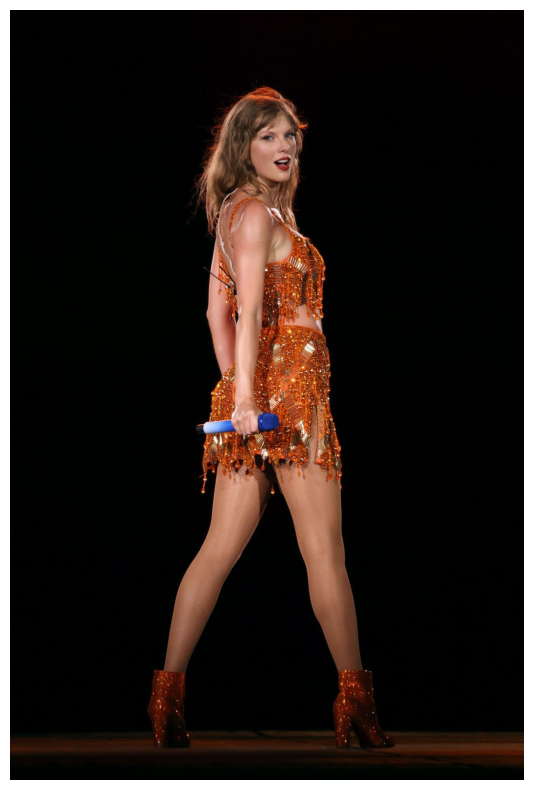

In [164]:
image = cv2.imread('Images_App_Test/1989_orange.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

In [165]:
transforms = A.Compose([
            A.Rotate(limit=40),
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.HorizontalFlip(),
            A.ShiftScaleRotate(p=0.5),
            A.Blur(blur_limit=3),
            A.OpticalDistortion(),
            A.GridDistortion(),
        ])

In [166]:
import os
import cv2
import random
import albumentations as A

# Define paths
dataset_path = 'train'  # Replace with your dataset path
augmented_dataset_path = 'augmented_train'  # Replace with desired output path

# Define augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),              # Horizontal flip with 50% probability
    A.VerticalFlip(p=0.5),                # Vertical flip with 50% probability
    A.RandomRotate90(p=0.5),              # Random 90-degree rotation with 50% probability
    A.RandomBrightnessContrast(p=0.5),      # Random brightness/contrast adjustments
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),  # Random shift, scale, and rotation
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),  # Random hue, saturation, and value adjustments
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),  # Gaussian blur with random kernel size
], p=1.0)  # Apply the entire pipeline with probability 1.0

# Function to augment images in a directory
def augment_images(source_dir, dest_dir, num_augmentations=SAMPLES_AUG_IMG):
    """
    Augments images in a source directory and saves them to a destination directory.

    Args:
        source_dir (str): Path to the directory containing the original images.
        dest_dir (str): Path to the directory where augmented images will be saved.
        num_augmentations (int): Number of augmentations to generate per image.
    """
    for filename in os.listdir(source_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(source_dir, filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            for i in range(num_augmentations):
                augmented_image = transform(image=image)['image']
                augmented_filename = f"{os.path.splitext(filename)[0]}_aug_{i}.jpg"
                augmented_path = os.path.join(dest_dir, augmented_filename)
                cv2.imwrite(augmented_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

# Create the augmented dataset directory structure
if not os.path.exists(augmented_dataset_path):
    os.makedirs(augmented_dataset_path)

# Iterate through classes and augment images
for class_name in os.listdir(dataset_path):
    class_source_dir = os.path.join(dataset_path, class_name)
    class_dest_dir = os.path.join(augmented_dataset_path, class_name)
    if not os.path.exists(class_dest_dir):
        os.makedirs(class_dest_dir)
    augment_images(class_source_dir, class_dest_dir)

print("Data augmentation complete!")

KeyboardInterrupt: 

In [ ]:
# Directory with the images
test_dir = "C:/Users/Ronan/Documents/ML/Taylor_Swift_Projects/CNN/test"
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    seed=42,
    label_mode='int',
    validation_split=None,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

In [ ]:
# Directory with the images
train_dir = "C:/Users/Ronan/Documents/ML/Taylor_Swift_Projects/CNN/augmented_train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    seed = 42,
    label_mode='int',
    validation_split=None,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

In [ ]:
# Directory with the images
val_dir = "C:/Users/Ronan/Documents/ML/Taylor_Swift_Projects/CNN/val"
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    seed = 42,
    label_mode='int',
    validation_split=None,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

In [ ]:
print(f"""
    ----------------------------------
    Dataset split:
        - train split: {len(train_ds)}
        - val split: {len(val_ds)}
        - test split: {len(test_ds)}
    ----------------------------------
    """
)

In [ ]:
#Caching the dataset

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
import os
import seaborn as sns
main_folder = 'augmented_train'

In [ ]:
era_counts = {}

# Iterate through each subfolder (era)
for era_folder in os.listdir(main_folder):
    era_path = os.path.join(main_folder, era_folder)
    if os.path.isdir(era_path):
        # Count the number of images in the era folder
        era_counts[era_folder] = len([filename for filename in os.listdir(era_path) if filename.lower().endswith(('.jpg', '.jpeg', '.png'))])

# Create a pandas DataFrame from the era_counts dictionary
import pandas as pd
df = pd.DataFrame({'Era': era_counts.keys(), 'Image Count': era_counts.values()})

# Create the bar plot using seaborn
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
ax = sns.barplot(x='Era', y='Image Count', data=df, palette='flare')  # Choose a color palette you like
for bar in range(len(ax.containers)):
    ax.bar_label(ax.containers[bar])
# Customize the plot
plt.title('Data Imbalance in Taylor Swift Eras Tour Images', fontsize=16)
plt.xlabel('Eras', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout for better spacing

# Display the plot
plt.show()

In [ ]:
def get_weight_inverse_num_samples(num_of_classes, samples_per_classes, coeff=1):
    """
    Get the inverse number of samples for each class.
    Args:
        num_of_classes (int): Number of classes in the dataset.
        samples_per_classes (list): List of number of samples per class.
        power (int, optional): Power of the inverse number of samples. Defaults to 1.
    Returns:
        list: List of inverse number of samples for each class.
    """

    inverse_num_samples = []
    total_samples = sum(samples_per_classes)

    for i in range(num_of_classes):
        inverse_num_samples.append((total_samples / (num_of_classes * samples_per_classes[i])) * coeff)

    return inverse_num_samples

num_of_classes = 10
samples_per_classes = [era_counts['1989'], era_counts['Acoustic'], era_counts['Fearless'], era_counts['Folkmore'], era_counts['Lover'], era_counts['Midnights'], era_counts['Red'], era_counts['Reputation'], era_counts['Speak Now'], era_counts['TTPD']] 

weighted_classes = get_weight_inverse_num_samples(num_of_classes, samples_per_classes)


In [ ]:
class_indexes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
weights = dict(zip(class_indexes, weighted_classes))

In [ ]:
weights

In [ ]:
conv_base = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    classifier_activation="softmax",
)

In [ ]:
for layer in conv_base.layers[:-8]:
    layer.trainable = False

In [ ]:
conv_base.summary()

Model: "efficientnetv2-s"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        648 │ rescaling[0][0]   │
│                     │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      5,184 │ stem_activation[… │
│ (Conv2D)            │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, None,      │          0 │ block1a_project_… │
│                     │ None, 24)         │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, None,      │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, None,      │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, None,      │          0 │ block1b_project_… │
│ (Activation)        │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, None,      │          0 │ block1b_project_… │
│ (Dropout)           │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, None,      │          0 │ block1b_drop[0][… │
│                     │ None, 24)         │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │     20,736 │ block1b_add[0][0] │
│ (Conv2D)            │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b

 Total params: 20,331,360 (77.56 MB)

 Trainable params: 723,968 (2.76 MB)

 Non-trainable params: 19,607,392 (74.80 MB)

In [ ]:
from tensorflow.keras.regularizers import l2

In [ ]:
inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

x = tf.keras.applications.efficientnet_v2.preprocess_input(inputs)

# The output of the base model is taken as the input for the new model
x = conv_base(x)
# This layer averages the spatial dimensions (height and width) of the output from the previous layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# Add a Dense layer with 512 units and 'relu' activation function to the model
x = tf.keras.layers.Dense(512, activation="relu")(x)
# This layer randomly sets a fraction of input units to 0 at each update during training time, which helps prevent overfitting
x = tf.keras.layers.Dropout(0.5)(x)
# This layer will output the probabilities for the 10 classes
outputs = tf.keras.layers.Dense(CLASSES, activation="softmax", kernel_regularizer=l2(0.001))(x)

#outputs = tf.keras.layers.Dense(CLASSES, activation="softmax")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 384, 384, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 12, 12, 1280)   │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,992,362 (80.08 MB)

 Trainable params: 1,384,970 (5.28 MB)

 Non-trainable params: 19,607,392 (74.80 MB)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras import callbacks

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
filepath="saved_models/all_VGG16_models/best_model_weighted_RESNET50_getty_aug.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
lr_plateau = callbacks.ReduceLROnPlateau(factor=0.8, monitor="val_accuracy", patience=5, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=ES_EPOCHS)
callbacks_list = [checkpoint, es, lr_plateau]

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    class_weight=weights
)

In [ ]:
filepath = "saved_models/all_VGG16_models/best_model_weighted_RESNET50_getty_aug.keras"
best_model = tf.keras.models.load_model(filepath)

In [ ]:
scores = best_model.predict(test_ds)

In [ ]:
def create_list_y(dataset, model):
  y_true = []
  y_pred = []

  for x, y in dataset:
    y_true.append(y)
    y_pred.append(tf.argmax(model.predict(x),axis = 1))
    
  y_pred = tf.concat(y_pred, axis=0)
  y_true = tf.concat(y_true, axis=0)

  return y_pred, y_true

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

y_pred, y_true = create_list_y(test_ds, best_model)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)

disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

Predictions

In [ ]:
from io import BytesIO
from PIL import Image

def read_file_as_img(file_path)-> np.ndarray:
    with open(file_path, 'rb') as f:
        data = f.read()
        image = np.array(Image.open(BytesIO(data)))

    return image

In [ ]:
# Load the tensorflow model
MODEL_PATH = "saved_models/all_VGG16_models/best_model_weighted_RESNET50_getty_aug.keras"

MODEL = tf.keras.models.load_model(MODEL_PATH)


In [ ]:
img = read_file_as_img("Images_App_Test/Lover.jpg")

In [ ]:
def classify_taylor_era(img, MODEL, top_n=3):
  """Classifies a given image using a pre-trained TensorFlow model 
  and returns the top n predicted Taylor Swift album classes.

  Args:
    img: The image to classify as a NumPy array.
    MODEL: The pre-trained TensorFlow model.
    top_n: The number of top predictions to return. Defaults to 3.

  Returns:
    A list of tuples, where each tuple contains the predicted class name and 
    its corresponding probability, sorted by probability in descending order.
  """
  img = tf.image.resize(img, [384, 384]) 

  # Predict the image classification
  img_batch = np.expand_dims(img, 0)
  predictions = MODEL.predict(img_batch)
  CLASS_NAMES = ["1989", "Acoustic", "Fearless", "Folkmore", "Lover", "Midnights", "Red", "Reputation", "Speak Now", "TTPD"]

  # Get the class label with the n highest probabilities
  top_indices = np.argpartition(predictions[0], -top_n)[-top_n:]
  top_probabilities = predictions[0][top_indices]
  top_classes = [CLASS_NAMES[i] for i in top_indices]

  # Sort results by probability in descending order
  results = sorted(zip(top_classes, top_probabilities), key=lambda x: x[1], reverse=True)
  
  return results

In [ ]:
classify_taylor_era(img, MODEL, top_n=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


[('Lover', 0.99784005), ('1989', 0.0012535492), ('TTPD', 0.00030981126)]

Model interpretation with GRAD Cam

In [286]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 384x384
    img = tf.keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (384, 384, 3)
    array = tf.keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 384, 384, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [287]:
img_path = "Images_App_Test/Rep.jpeg"

In [288]:
img_array = tf.keras.applications.efficientnet_v2.preprocess_input(get_img_array(img_path, (384,384)))

In [289]:
preds = MODEL.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


In [290]:
preds

array([[4.3778982e-05, 3.1712691e-06, 4.5957713e-05, 1.4620498e-05,
        3.7601206e-04, 4.9144361e-04, 1.0214724e-03, 9.9797660e-01,
        2.5672955e-06, 2.4309411e-05]], dtype=float32)

In [291]:
CLASS_NAMES[np.argmax(preds[0])]

'Reputation'

In [292]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [293]:
heatmap = make_gradcam_heatmap(img_array, conv_base, "top_conv", np.argmax(preds[0]))

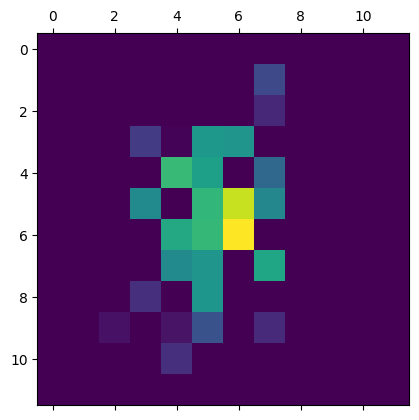

In [294]:
# Display heatmap
plt.matshow(heatmap)
plt.show()

In [295]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

def save_and_display_gradcam(img_path, heatmap, cam_path="new_cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]  # Correct way to get the 'jet' colormap

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

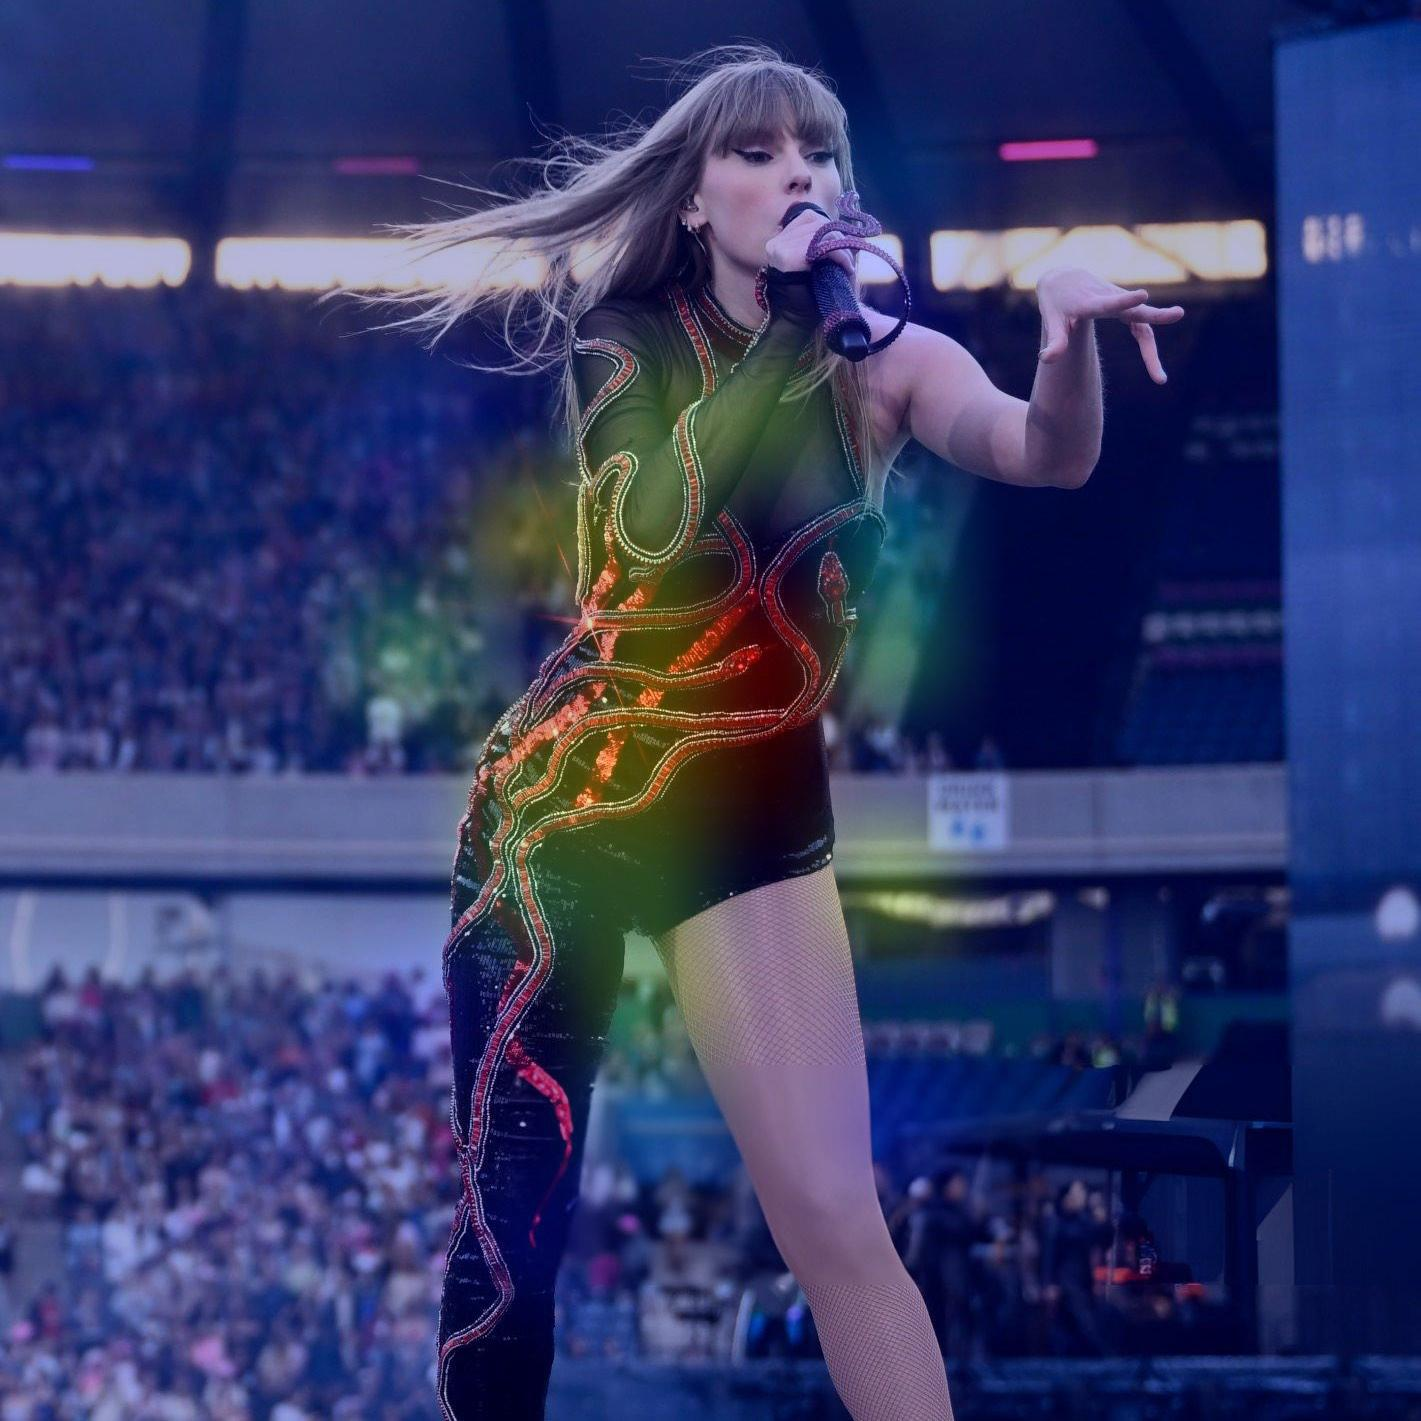

In [296]:
save_and_display_gradcam(img_path, heatmap)